# Прекод

# Сборный проект-5

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.image as mpimg
import os

## Константы

In [ ]:
RANDOME_STATE = 20
THRESHOLD = 0.6

## Функции проекта

In [3]:
def plot_distribution_with_stats(data, x_column, agg_column=None, title=None):
    """
    Строит гистограмму распределения с линиями статистик (квантили 5%, 50%, 95% и среднее)
    
    Parameters:
    -----------
    data : pandas.DataFrame или str
        DataFrame или путь к файлу с данными
    x_column : str
        Название столбца для построения гистограммы
    agg_column : str, optional
        Столбец для агрегации (если нужно агрегировать значения)
    title : str, optional
        Заголовок графика
    """
    
    # Если на вход подали строку (путь к файлу)
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data.copy()
    
    # Если указан столбец для агрегации, применяем value_counts
    if agg_column:
        plot_data = df[agg_column].value_counts()
        x_label = agg_column
    else:
        plot_data = df[x_column]
        x_label = x_column
    
    plt.figure(figsize=(12, 5))
    
    # Определяем bins для гистограммы
    if agg_column:
        bins = len(plot_data)
        data_for_stats = plot_data.index
        values = plot_data.values
    else:
        bins = len(plot_data.unique())
        data_for_stats = plot_data
        values = plot_data
    
    plt.hist(data_for_stats, bins=bins, alpha=0.7, edgecolor='black')
    
    # Вычисляем статистики
    quantile_05 = data_for_stats.quantile(0.05)
    quantile_50 = data_for_stats.quantile(0.5)
    quantile_95 = data_for_stats.quantile(0.95)
    mean_val = data_for_stats.mean()
    
    # Максимальная частота для высоты линий
    if agg_column:
        max_freq = values.max()
    else:
        max_freq = data_for_stats.value_counts().max()
    
    # Добавляем вертикальные линии
    stats_config = [
        (quantile_05, 'r', '5% значений'),
        (quantile_95, 'r', '95% значений'),
        (quantile_50, 'b', '50% значений'),
        (mean_val, 'orange', 'среднее')
    ]
    
    for x_val, color, label in stats_config:
        plt.vlines(
            x=x_val,
            ymin=0,
            ymax=max_freq + 5,
            colors=color,
            label=label,
            linewidth=2
        )
    
    # Настройка графика
    plt.title(title or f'Распределение {x_label}')
    plt.ylim(top=max_freq + 5)
    plt.legend()
    plt.ylabel('Частота')
    plt.xlabel(x_label)
    
    # Настройка ticks для возраста
    if x_column == 'real_age':
        plt.xticks(range(0, int(data_for_stats.max()), 2))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Возвращаем статистики для анализа
    stats = {
        '5% квантиль': quantile_05,
        '50% квантиль (медиана)': quantile_50,
        '95% квантиль': quantile_95,
        'среднее': mean_val
    }
    
    return stats


def process_expert_data_simple(df, expert_cols=['exp_1', 'exp_2', 'exp_3'], threshold=0.66):
    """
    Обработка решения экспертов
    """
    result = df.copy()
    
    # Шаг 1: Мажоритарное голосование
    def majority_vote(row):
        votes = row[expert_cols].values
        vote_counts = pd.Series(votes).value_counts()
        return vote_counts.index[0] if vote_counts.iloc[0] >= 2 else np.nan
    
    result['major_target'] = result.apply(majority_vote, axis=1)
    result = result.dropna(subset=['major_target']).copy()
    result['major_target'] = result['major_target'].astype(int)
    
    # # Шаг 2: Нормализация
    # min_val, max_val = 1, 4
    # result['normalize_target'] = (result['major_target'] - min_val) / (max_val - min_val)
    
    # # Шаг 3: Бинаризация
    # result['expert_target'] = (result['normalize_target'] >= threshold).astype(int)
    
    return result

def show_image_with_all_queries(image_name, merged_df, train_df,
                                images_folder="../data/train_images/",
                                max_queries=5, image_width_inches=5):
    """
    Отображает изображение и только те описания, у которых есть таргет из merged_df.
    Изображение масштабируется к заданной ширине, высота подбирается пропорционально.
    Левая и правая панели выравниваются по вертикали.

    Parameters:
    -----------
    image_name : str
        Название файла изображения
    merged_df : DataFrame
        Датафрейм с колонками image, text_id, normalize_target
    train_df : DataFrame
        Датафрейм с колонками image, query_id, query_text
    images_folder : str
        Путь к папке с изображениями
    max_queries : int
        Максимальное количество описаний для отображения
    image_width_inches : float
        Ширина изображения в дюймах (левая панель)
    """
    # Путь к изображению
    img_path = os.path.join(images_folder, image_name)

    if not os.path.exists(img_path):
        print(f"Файл не найден: {img_path}")
        return

    # Данные для этого image
    merged_for_image = merged_df[merged_df['image'] == image_name]
    if len(merged_for_image) == 0:
        print(f"Нет данных для изображения {image_name} в merged_df")
        return

    train_for_image = train_df[train_df['image'] == image_name]

    # Словарь таргетов
    target_dict = {row['text_id']: row['normalize_target'] for _, row in merged_for_image.iterrows()}

    # Описания с таргетом
    descriptions = []
    for _, row in train_for_image.iterrows():
        if row['query_id'] in target_dict:
            descriptions.append({
                'query_id': row['query_id'],
                'query_text': row['query_text'],
                'normalize_target': target_dict[row['query_id']]
            })
    descriptions.sort(key=lambda x: x['normalize_target'], reverse=True)

    # Загружаем изображение для определения пропорций
    img = mpimg.imread(img_path)
    img_height, img_width = img.shape[:2]
    aspect = img_height / img_width
    image_height_inches = image_width_inches * aspect

    # Создаём фигуру: левая панель фиксированной ширины, правая подстраивается
    # Общая ширина фигуры = ширина картинки + ширина текста (например, 8 дюймов)
    text_width_inches = 8
    fig_width = image_width_inches + text_width_inches
    fig_height = max(image_height_inches, 6)  # минимальная высота для текста

    fig = plt.figure(figsize=(fig_width, fig_height))

    # Создаём оси вручную, чтобы точно контролировать положение
    left = 0.05
    bottom = 0.05
    right_image = left + image_width_inches / fig_width
    right_text = 0.95

    ax1 = fig.add_axes([left, bottom, image_width_inches / fig_width, image_height_inches / fig_height])
    ax2 = fig.add_axes([right_image + 0.02, bottom, (right_text - right_image - 0.02), image_height_inches / fig_height])

    # Отображаем изображение
    ax1.imshow(img)
    ax1.set_title(f"{image_name}\nописаний с таргетом: {len(descriptions)}", fontsize=10)
    ax1.axis('off')

    # Текстовая информация
    ax2.axis('off')
    total_in_merged = len(merged_for_image)
    total_in_train = len(train_for_image)
    total_with_target = len(descriptions)

    text_str = f"ИЗОБРАЖЕНИЕ: {image_name}\n"
    text_str += "="*50 + "\n\n"
    text_str += f"Статистика:\n"
    text_str += f"записей в merged_df: {total_in_merged}\n"
    text_str += f"описаний в train_df: {total_in_train}\n"
    text_str += f"описаний С ТАРГЕТОМ: {total_with_target}\n\n"

    if total_with_target > 0:
        pos = sum(1 for d in descriptions if d['normalize_target'] >= THRESHOLD)
        neg = total_with_target - pos
        text_str += f"Классы:\n"
        text_str += f"положительных (>={THRESHOLD}): {pos}\n"
        text_str += f"отрицательных (<{THRESHOLD}): {neg}\n\n"

        text_str += f"ОПИСАНИЯ С ТАРГЕТОМ:\n" + "-"*50 + "\n"
        num_to_show = min(max_queries, total_with_target)
        for i in range(num_to_show):
            d = descriptions[i]
            qtext = d['query_text'] if len(d['query_text']) <= 150 else d['query_text'][:150] + "..."
            symb = '🟢' if d['normalize_target'] >= THRESHOLD else '🔴'
            text_str += f"{symb} {i+1}: normalize_target {d['normalize_target']:.3f}\n"
            text_str += f"   {qtext}\n" + "-"*30 + "\n"

        if total_with_target > max_queries:
            text_str += f"\n... и ещё {total_with_target - max_queries}\n"

        avg = sum(d['normalize_target'] for d in descriptions) / total_with_target
        text_str += f"\nСредний normalize_target: {avg:.3f}\n"
    else:
        text_str += "НЕТ ОПИСАНИЙ С ТАРГЕТОМ\n"
        if len(train_for_image) > 0:
            text_str += "\nПримеры без таргета:\n"
            for _, row in train_for_image.head(3).iterrows():
                text_str += f"   {row['query_id']}\n"

    ax2.text(0.01, 0.99, text_str, transform=ax2.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

    plt.show()

    # return {
    #     'image': image_name,
    #     'total_in_merged': total_in_merged,
    #     'total_in_train': total_in_train,
    #     'with_target': total_with_target,
    #     'positive': pos if total_with_target > 0 else 0,
    #     'negative': neg if total_with_target > 0 else 0
    # }


def show_random_images_with_all_queries(merged_df, train_df, num_images=3,
                                        images_folder="../data/train_images/",
                                        max_queries=5, random_state=None,
                                        min_with_target=1, image_width_inches=5):
    """
    Показывает случайные изображения, у которых есть хотя бы min_with_target описаний с таргетом.
    """
    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    required_cols = ['image', 'text_id', 'normalize_target']
    missing = [c for c in required_cols if c not in merged_df.columns]
    if missing:
        print(f"В merged_df отсутствуют: {missing}")
        return

    # Отбираем изображения с нужным числом описаний, имеющих таргет
    images_with_target = []
    for img in merged_df['image'].unique():
        mdf = merged_df[merged_df['image'] == img]
        tdf = train_df[train_df['image'] == img]
        if len(tdf) == 0:
            continue
        target_ids = set(mdf['text_id'].values)
        cnt = sum(1 for tid in tdf['query_id'].values if tid in target_ids)
        if cnt >= min_with_target:
            images_with_target.append(img)

    if not images_with_target:
        print(f"Нет изображений с ≥ {min_with_target} описаниями, имеющими таргет")
        return

    print("="*80)
    print("СЛУЧАЙНЫЕ ИЗОБРАЖЕНИЯ (только с описаниями, имеющими таргет)")
    print("="*80)
    print(f"Всего уникальных изображений в merged_df: {len(merged_df['image'].unique())}")
    print(f"Изображений с ≥ {min_with_target} описанием с таргетом: {len(images_with_target)}")
    print(f"Всего пар в merged_df: {len(merged_df)}")
    pos = len(merged_df[merged_df['normalize_target'] >= 0.66])
    neg = len(merged_df) - pos
    print(f"положительных: {pos} ({pos/len(merged_df)*100:.1f}%)")
    print(f"отрицательных: {neg} ({neg/len(merged_df)*100:.1f}%)")
    print("-"*80)

    selected = random.sample(images_with_target, min(num_images, len(images_with_target)))
    results = []
    for i, img_name in enumerate(selected, 1):
        print(f"\nИзображение {i}/{len(selected)}: {img_name}")
        mdf = merged_df[merged_df['image'] == img_name]
        tdf = train_df[train_df['image'] == img_name]
        target_ids = set(mdf['text_id'].values)
        with_target = sum(1 for tid in tdf['query_id'].values if tid in target_ids)
        print(f"в merged_df: {len(mdf)} записей, в train_df: {len(tdf)} описаний, с таргетом: {with_target}")
        res = show_image_with_all_queries(
            img_name, merged_df, train_df,
            images_folder=images_folder,
            max_queries=max_queries,
            image_width_inches=image_width_inches
        )
    #     results.append(res)
    # return results

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Подгрузим данные

In [4]:
crowd_df = pd.read_csv("../data/CrowdAnnotations.tsv", sep='\\s+')
expert_df = pd.read_csv("../data/ExpertAnnotations.tsv", sep='\\s+')
test_images = pd.read_csv("../data/test_images.csv")
test_queries = pd.read_csv("../data/test_queries.csv", sep='|')
train_df = pd.read_csv("../data/train_dataset.csv")

### Изучим содержимое данных

#### Оценки

##### crowd_df

In [5]:
crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   1056338697_4f7d7ce270.jpg    47829 non-null  object 
 1   1056338697_4f7d7ce270.jpg#2  47829 non-null  object 
 2   1                            47829 non-null  float64
 3   3                            47829 non-null  int64  
 4   0                            47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [6]:
# у нас нет названий столбцов, добавим
crowd_df.columns = ['image', 'text_id', 'true_%', 'true_count', 'false_count']

In [7]:
display(crowd_df.sample(5))
display(crowd_df.info())

,image,text_id,true_%,true_count,false_count
586,114051287_dd85625a04.jpg,3016606751_0e8be20abd.jpg#2,0.0,0,3
6984,2182488373_df73c7cc09.jpg,543007912_23fc735b99.jpg#2,0.0,0,3
46899,757332692_6866ae545c.jpg,3363750526_efcedc47a9.jpg#2,0.0,0,3
34013,3442242092_e579538d82.jpg,523985664_c866af4850.jpg#2,0.0,0,3
40071,3651971126_309e6a5e22.jpg,3070011270_390e597783.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47829 non-null  object 
 1   text_id      47829 non-null  object 
 2   true_%       47829 non-null  float64
 3   true_count   47829 non-null  int64  
 4   false_count  47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

In [8]:
crowd_df.describe().T

,count,mean,std,min,25%,50%,75%,max
true_%,47829.0,0.068766,0.207490,0.0,0.0,0.0,0.0,1.0
true_count,47829.0,0.208430,0.628775,0.0,0.0,0.0,0.0,5.0
false_count,47829.0,2.820214,0.656556,0.0,3.0,3.0,3.0,6.0


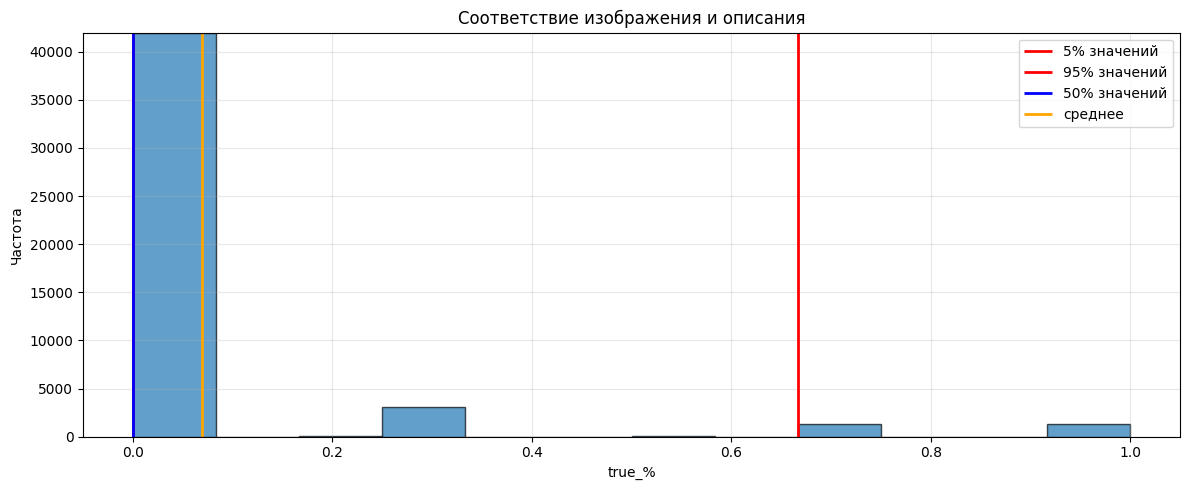

{'5% квантиль': np.float64(0.0),
 '50% квантиль (медиана)': np.float64(0.0),
 '95% квантиль': np.float64(0.666666666666667),
 'среднее': np.float64(0.06876616000055753)}

In [9]:
plot_distribution_with_stats(crowd_df, 'true_%', agg_column=None, title='Соответствие изображения и описания')

Как видим, в данном отчете преобладает то, что текст не соовтетствует описанию, по мнению респондентов.  
В любом случае добавим target, где 1 соответствует при условии, что true_% > 0.66, а все, что ниже - 0.

In [10]:
# crowd_df['crowd_target'] = np.where(crowd_df['true_%'] >= 0.66, 1, 0)

In [11]:
crowd_df['true_%'].value_counts()

true_%
0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1322
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: count, dtype: int64

In [12]:
entries_per_image = crowd_df.groupby("image").size().reset_index(name="total_entries")
avg_entries = entries_per_image["total_entries"].mean()
display(f"Среднее количество записей на image: {avg_entries:.2f}")

'Среднее количество записей на image: 47.83'

Слишком много описаний для одной картинки, в итогом варианте оставим только те, у кого оценка выше 0,66

##### expert_df

Теперь посмотрим, как оценили эксперты наши данные

In [13]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   1056338697_4f7d7ce270.jpg    5821 non-null   object
 1   2549968784_39bfbe44f9.jpg#2  5821 non-null   object
 2   1                            5821 non-null   int64 
 3   1.1                          5821 non-null   int64 
 4   1.2                          5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


6000 фотографий против 48000, по всей видимости, качество оценки будет не очень, но это не точно  
позже оценим сравнение как крауда, так и экспертов

In [14]:
expert_df.columns = ['image', 'text_id', 'exp_1', 'exp_2', 'exp_3']

In [15]:
display(expert_df.sample(5))
display(expert_df.info())

,image,text_id,exp_1,exp_2,exp_3
5431,506738508_327efdf9c3.jpg,3301811927_a2797339e5.jpg#2,1,1,1
1398,2443380641_7b38d18f5b.jpg,3028969146_26929ae0e8.jpg#2,1,1,1
3675,3281078518_630a7a7f4f.jpg,3514019869_7de4ece2a5.jpg#2,1,1,1
2358,2870875612_2cbb9e4a3c.jpg,2396025708_e4a72e2558.jpg#2,2,2,2
1068,226607225_44d696db6b.jpg,2559921948_06af25d566.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    5821 non-null   object
 1   text_id  5821 non-null   object
 2   exp_1    5821 non-null   int64 
 3   exp_2    5821 non-null   int64 
 4   exp_3    5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

In [16]:
expert_df.describe().T

,count,mean,std,min,25%,50%,75%,max
exp_1,5821.0,1.436695,0.787130,1.0,1.0,1.0,2.0,4.0
exp_2,5821.0,1.624463,0.856256,1.0,1.0,1.0,2.0,4.0
exp_3,5821.0,1.882151,0.904091,1.0,1.0,2.0,2.0,4.0


In [17]:
# соберем таргет по следующей цепочке - 
# 1) получаем результат посредством мажоритарного голосования (спорное удаляем)
# 2) далее нормализуем между 0 и 1
# 3) далее по принципу >= THRESHOLD это 1 иначе 0

expert_df = process_expert_data_simple(expert_df, expert_cols=['exp_1', 'exp_2', 'exp_3'], threshold=THRESHOLD)

In [18]:
display(expert_df.sample(5))
display(expert_df.describe().T)

,image,text_id,exp_1,exp_2,exp_3,major_target
2512,2918769188_565dd48060.jpg,3458559770_12cf9f134e.jpg#2,1,1,2,1
2881,3062173277_bfb5ef4c45.jpg,1764955991_5e53a28c87.jpg#2,1,1,1,1
1027,2238759450_6475641bdb.jpg,2764178773_d63b502812.jpg#2,1,1,1,1
2342,2866254827_9a8f592017.jpg,2544182005_3aa1332bf9.jpg#2,1,2,2,2
4634,3584534971_b44f82c4b9.jpg,2421446839_fe7d46c177.jpg#2,1,1,1,1


,count,mean,std,min,25%,50%,75%,max
exp_1,5695.0,1.441791,0.792755,1.0,1.0,1.0,2.0,4.0
exp_2,5695.0,1.611589,0.859137,1.0,1.0,1.0,2.0,4.0
exp_3,5695.0,1.852502,0.889396,1.0,1.0,2.0,2.0,4.0
major_target,5695.0,1.611589,0.859137,1.0,1.0,1.0,2.0,4.0


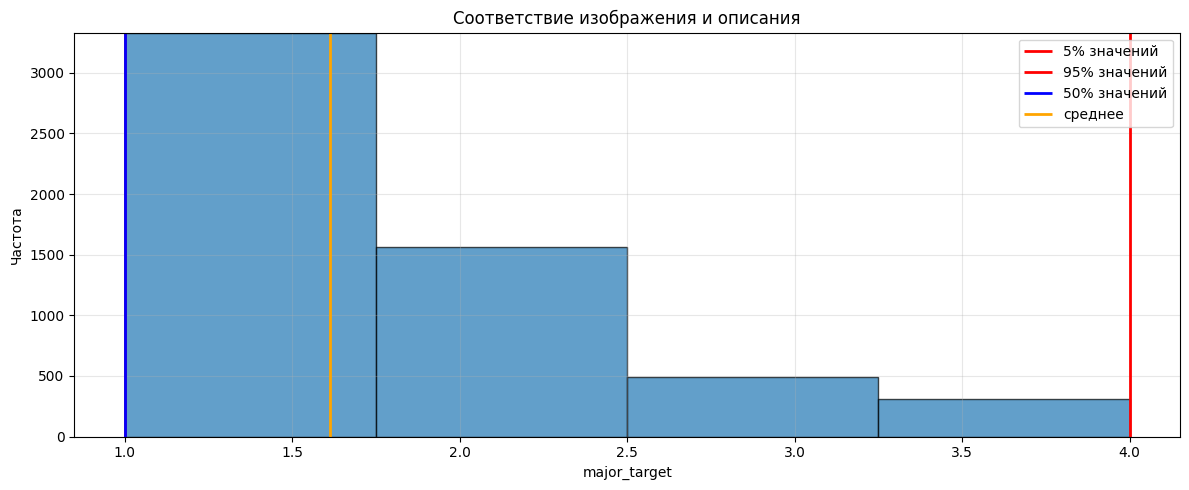

{'5% квантиль': np.float64(1.0),
 '50% квантиль (медиана)': np.float64(1.0),
 '95% квантиль': np.float64(4.0),
 'среднее': np.float64(1.6115891132572433)}

In [19]:
# plot_distribution_with_stats(expert_df, 'normalize_target', agg_column=None, title='Соответствие изображения и описания')
plot_distribution_with_stats(expert_df, 'major_target', agg_column=None, title='Соответствие изображения и описания')

Таким образом - мнение экспертов совпадает в целом с мнением крауд разметчиков.  
Значит теперь надо как-то все это обэединить и сделать усредненные значения....

In [20]:
entries_per_image = expert_df.groupby("image").size().reset_index(name="total_entries")
avg_entries = entries_per_image["total_entries"].mean()
display(f"Среднее количество записей на image: {avg_entries:.2f}")

'Среднее количество записей на image: 5.70'

Вот тут уже ближе к правде, по числу описаний

##### объединение оценок

In [21]:
merged_df = pd.merge(
    expert_df, 
    crowd_df, 
    on=['image', 'text_id'], 
    how='inner',
    suffixes=('_expert', '_crowd')
)

In [22]:
merged_df.sample(5)

,image,text_id,exp_1,exp_2,exp_3,major_target,true_%,true_count,false_count
419,2301525531_edde12d673.jpg,401079494_562454c4d6.jpg#2,1,1,2,1,0.000000,0,3
1085,302983277_69a4e732e4.jpg,57422853_b5f6366081.jpg#2,2,2,2,2,0.000000,0,3
1325,3217620013_8b17873273.jpg,2994179598_a45c2732b5.jpg#2,2,3,3,3,0.333333,1,2
877,2844018783_524b08e5aa.jpg,170100272_d820db2199.jpg#2,1,1,1,1,0.000000,0,3
584,249394748_2e4acfbbb5.jpg,2573625591_70291c894a.jpg#2,3,3,3,3,0.666667,2,1


Теперь сделаем финальный таргет - возьмем коэффициенты.  
0 так и остается 0  
коэффициент для экспертов это 0,7  
коэффициент для крауда это 0,3  
просуммируем и нормализуем - это и будет финальная оценка качества описания

In [45]:
merged_df["sum_target"] = (merged_df["major_target"] * 0.8) + (merged_df["true_%"] * 0.2)
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
exp_1,2257.0,1.959238,0.988912,1.0,1.0,2.000000,3.000000,4.0
exp_2,2257.0,2.197607,0.981628,1.0,1.0,2.000000,3.000000,4.0
exp_3,2257.0,2.459016,0.929820,1.0,2.0,2.000000,3.000000,4.0
major_target,2257.0,2.197607,0.981628,1.0,1.0,2.000000,3.000000,4.0
true_%,2257.0,0.200066,0.345807,0.0,0.0,0.000000,0.333333,1.0
true_count,2257.0,0.608330,1.052640,0.0,0.0,0.000000,1.000000,5.0
false_count,2257.0,2.429331,1.065451,0.0,2.0,3.000000,3.000000,6.0
sum_target,2257.0,1.798099,0.839597,0.8,0.8,1.600000,2.450000,3.4
normalize_target,2257.0,0.381886,0.322430,0.0,0.0,0.304348,0.630435,1.0
target,2257.0,0.135135,0.341944,0.0,0.0,0.000000,0.000000,1.0


In [46]:
min_value = merged_df["sum_target"].min()
max_value = merged_df["sum_target"].max()

display(min_value)
display(max_value)

np.float64(0.8)

np.float64(3.4000000000000004)

In [47]:
# нормализация
merged_df['normalize_target'] = (merged_df['sum_target'] - min_value) / (max_value - min_value)

# бинаризация
merged_df['target'] = (merged_df['normalize_target'] >= THRESHOLD).astype(int)

In [48]:
merged_df

,image,text_id,exp_1,exp_2,exp_3,major_target,true_%,true_count,false_count,sum_target,normalize_target,target
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1,0.000000,0,3,0.800000,0.000000,0
1,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2,1,0.000000,0,3,0.800000,0.000000,0
2,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,2,3,3,3,0.333333,1,2,2.466667,0.641026,0
3,1084040636_97d9633581.jpg,3396157719_6807d52a81.jpg#2,1,2,2,2,0.000000,0,3,1.600000,0.307692,0
4,1096395242_fc69f0ae5a.jpg,1425069308_488e5fcf9d.jpg#2,2,2,2,2,0.000000,0,3,1.600000,0.307692,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2252,979383193_0a542a059d.jpg,3244747165_17028936e0.jpg#2,2,2,2,2,0.000000,0,3,1.600000,0.307692,0
2253,979383193_0a542a059d.jpg,3482062809_3b694322c4.jpg#2,1,2,2,2,0.000000,0,3,1.600000,0.307692,0
2254,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1,0.000000,0,3,0.800000,0.000000,0
2255,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1,0.000000,0,3,0.800000,0.000000,0


СЛУЧАЙНЫЕ ИЗОБРАЖЕНИЯ (только с описаниями, имеющими таргет)
Всего уникальных изображений в merged_df: 885
Изображений с ≥ 1 описанием с таргетом: 885
Всего пар в merged_df: 2257
положительных: 417 (18.5%)
отрицательных: 1840 (81.5%)
--------------------------------------------------------------------------------

Изображение 1/3: 3186073578_6e115f45f5.jpg
в merged_df: 1 записей, в train_df: 5 описаний, с таргетом: 1


e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


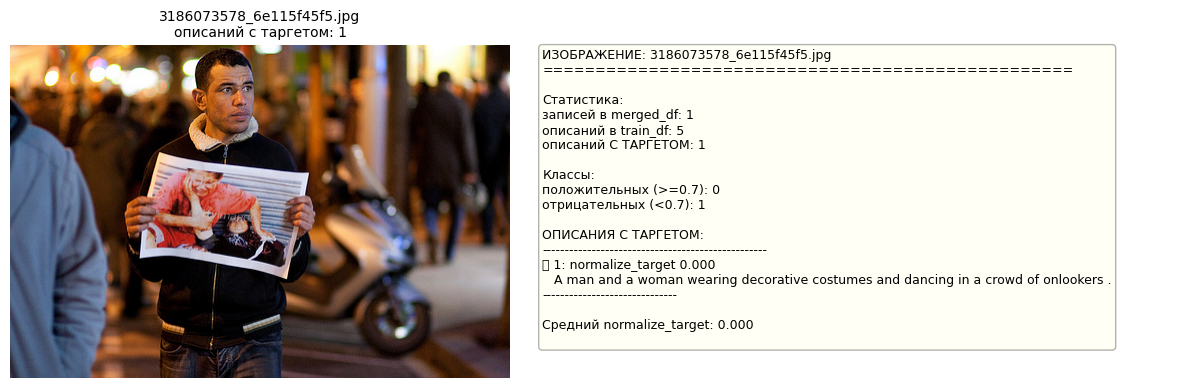


Изображение 2/3: 3741462565_cc35966b7a.jpg
в merged_df: 2 записей, в train_df: 6 описаний, с таргетом: 2


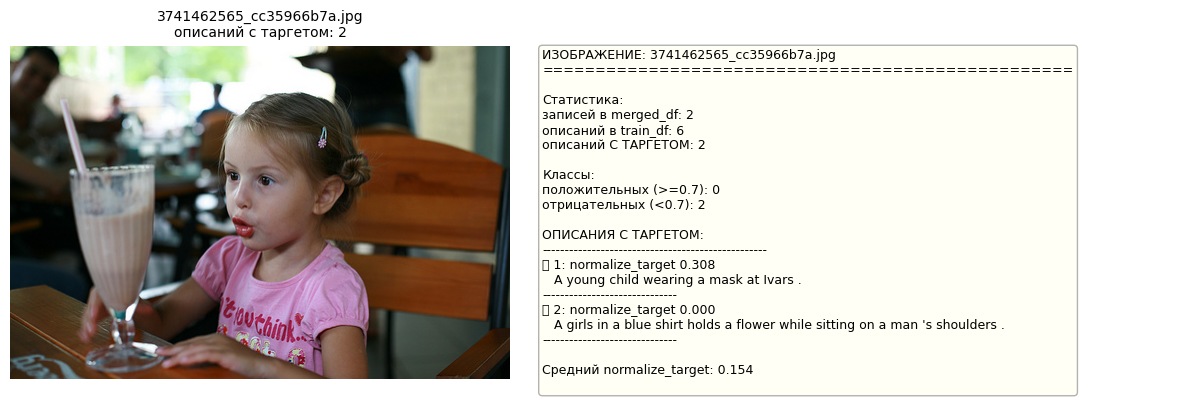


Изображение 3/3: 3540416981_4e74f08cbb.jpg
в merged_df: 5 записей, в train_df: 5 описаний, с таргетом: 5


e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


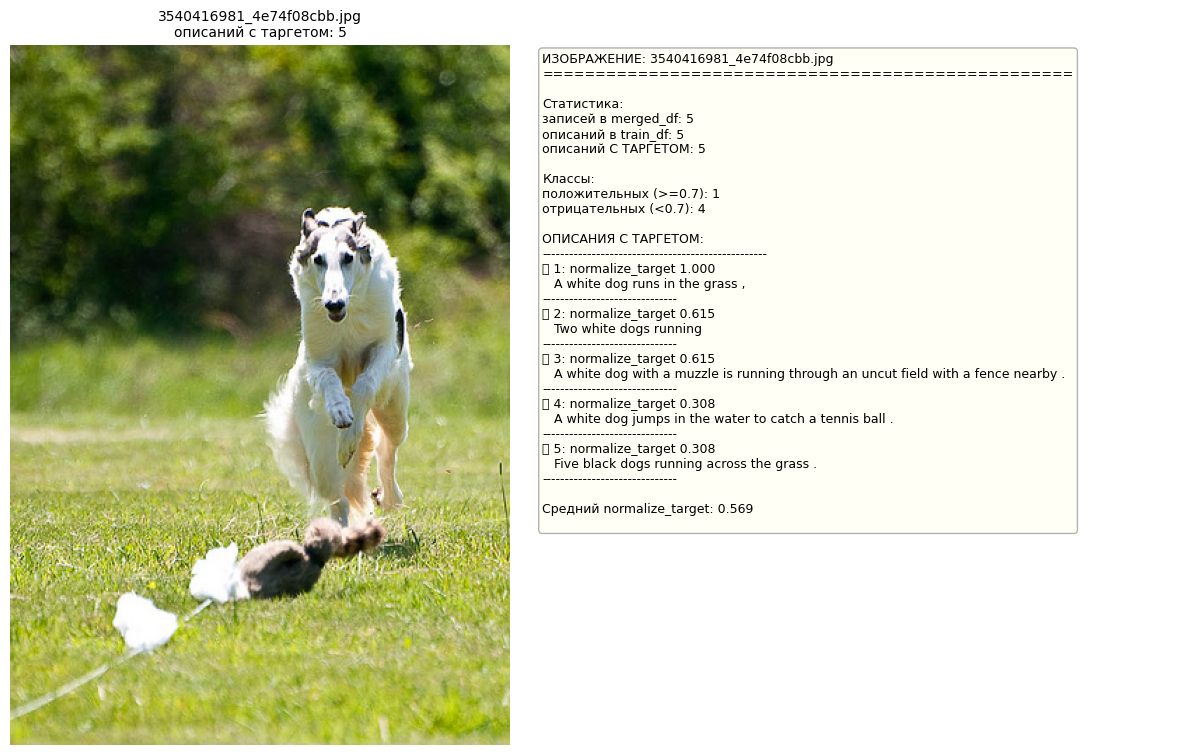

In [50]:
show_random_images_with_all_queries(
    merged_df=merged_df,
    train_df=train_df,
    num_images=3,
    max_queries=5
)

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

***********************  
А я же могу тут пойти против шерсти? :)  
Не хочу удалять, хочу через обработку запросов и текущией оценки получившейся просто алерт выводить вместо фотки...  
***********************

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска